In [63]:
import argparse
import re
import networkx as nx
import scipy as scipy
import matplotlib.pyplot as plt # for visualizing GMLs
import os
import itertools
%matplotlib inline
import pandas as pd
import numpy as np
import sklearn.metrics as sklearn_metrics
from sklearn.metrics import rand_score,mutual_info_score,adjusted_rand_score,adjusted_mutual_info_score

In [ ]:
# Mapping Clusters of Orthologous Genes (COGs) between two pan-genome gene graphs

In [64]:
# define functions to read in graphs with metadata

def conv_list(maybe_list):
    if not isinstance(maybe_list, list):
        maybe_list = [maybe_list]
    return (maybe_list)

def update_sid(sid, member_count):
    sid = sid.split("_")
    sid[0] = str(member_count + int(sid[0].replace("'", "")))
    return ("_".join(sid))

def del_dups(iterable):
    seen = {}
    for f in iterable:
        seen[f] = None
    return (list(seen.keys()))

def load_graphs(graph_files, n_cpu=1):
    for graph_file in graph_files:
        if not os.path.isfile(graph_file):
            print("Missing:", graph_file)
            raise RuntimeError("Missing graph file!")

    graphs = [nx.read_gml(graph_file) for graph_file in graph_files]
    isolate_names = list(
        itertools.chain.from_iterable(
            [G.graph['isolateNames'] for G in graphs]))

    member_count = 0
    node_count = 0
    id_mapping = []
    for i, G in enumerate(graphs):
        id_mapping.append({})
        # relabel nodes to be consecutive integers from 1
        mapping = {}
        for n in G.nodes():
            mapping[n] = node_count
            node_count += 1
        G = nx.relabel_nodes(G, mapping, copy=True)

        # set up edge members and remove conflicts.
        for e in G.edges():
            G[e[0]][e[1]]['members'] = [
                m + member_count for m in conv_list(G[e[0]][e[1]]['members'])
            ]

        # set up node parameters and remove conflicts.
        max_mem = -1
        for n in G.nodes():
            ncentroids = []
            for sid in G.nodes[n]['centroid'].split(";"):
                nid = update_sid(sid, member_count)
                id_mapping[i][sid] = nid
                if "refound" not in nid:
                    ncentroids.append(nid)
            G.nodes[n]['centroid'] = ncentroids
            new_ids = set()
            for sid in conv_list(G.nodes[n]['seqIDs']):
                nid = update_sid(sid, member_count)
                id_mapping[i][sid] = nid
                new_ids.add(nid)
            G.nodes[n]['seqIDs'] = new_ids
            G.nodes[n]['protein'] = del_dups(G.nodes[n]['protein'].replace(
                '*', 'J').split(";"))
            G.nodes[n]['dna'] = del_dups(G.nodes[n]['dna'].split(";"))
            G.nodes[n]['lengths'] = conv_list(G.nodes[n]['lengths'])
            G.nodes[n]['longCentroidID'][1] = update_sid(
                G.nodes[n]['longCentroidID'][1], member_count)
            G.nodes[n]['members'] = [m + member_count for m in conv_list(G.nodes[n]['members'])]
            max_mem = max(max_mem, max(G.nodes[n]['members']))

        member_count = max_mem + 1
        graphs[i] = G

    return graphs, isolate_names, id_mapping

In [65]:
### read in two graphs

graph_files = ["/nfs/research/jlees/jacqueline/atb_analyses/merge_tests/staph_merge/graph_1/final_graph.gml", "/nfs/research/jlees/jacqueline/atb_analyses/merge_tests/staph_merge/graph_2/final_graph.gml"]

graphs, isolate_names, id_mapping = load_graphs(graph_files)

sim_graph_04 = graphs[0]
sim_graph_59 = graphs[1]

#list(sim_graph_04.nodes(data=True))

In [66]:
# change geneIDs to unique geneIDs (since geneIDs not unique between graphs)

def geneID_to_uGID(G, graph_id):
    
    for node in G.nodes():
        node_GIDs = G.nodes[node].get("geneIDs", "error")
        #print(f"node_GIDs: {node_GIDs}")
        node_GIDs_split = ";".join(str(f"uGID_{graph_id}_{GID}") for GID in node_GIDs.split(";"))
        G.nodes[node]["geneIDs"] = node_GIDs_split
        #print("UGIDs: ", G.nodes[node].get("geneIDs", "error"))

    return G

sim_graph_04 = geneID_to_uGID(sim_graph_04, "G1")
sim_graph_59 = geneID_to_uGID(sim_graph_59, "G2")

#print(sim_graph_04.nodes[0].get("geneIDs", "error"))
#print(sim_graph_59.nodes[3824].get("geneIDs", "error"))

In [67]:
### map nodes from ggcaller graphs to the COG labels in the centroid from pangenome

# read into df
# each "group_" refers to the centroid of that group in the pan_genomes_reference.fa
mmseqs = pd.read_csv('/nfs/research/jlees/jacqueline/atb_analyses/merge_tests/staph_merge/graph_merged/mmseqs_alignments.m8', sep='\t')

In [68]:
### match hits from mmseqs

# change the second graph node names to the first graph node names for nodes that match according to mmseqs

# make sure metrics are numeric
mmseqs["fident"] = pd.to_numeric(mmseqs["fident"], errors='coerce')
mmseqs["evalue"] = pd.to_numeric(mmseqs["evalue"], errors='coerce')
mmseqs["tlen"] = pd.to_numeric(mmseqs["tlen"], errors='coerce')
mmseqs["qlen"] = pd.to_numeric(mmseqs["qlen"], errors='coerce')
mmseqs["nident"] = pd.to_numeric(mmseqs["nident"], errors='coerce')

# filter for nt identity >= 98% (global) and length difference <= 5%
max_len = np.maximum(mmseqs['tlen'], mmseqs['qlen'])
nt_identity = mmseqs['nident'] / max_len  >= 0.98
nt_identity = max_len / max_len  >= 0.98
len_dif = 1-(np.abs(mmseqs['tlen'] - mmseqs['qlen']) / max_len) >= 0.95

scores = nt_identity & len_dif
mmseqs = mmseqs[scores].copy()

# iterate over target with each unique value of target, and pick the match with the highest fident; if multiple, pick the one with the smaller E value

# sort by fident (highest first) and evalue (lowest first)
mmseqs_sorted = mmseqs.sort_values(by=["fident", "evalue"], ascending=[False, True])

# only keep the first occurrence per unique target (highest fident then smallest evalue if tie)
mmseqs_filtered = mmseqs_sorted.groupby("target", as_index=False).first()

# remove "group_" prefix, keep as string
#mmseqs_filtered = mmseqs_filtered.applymap(lambda x: x.replace("group_", "") if isinstance(x, str) else x)

In [69]:
# in mmseqs, the first graph entered (in this case graph_1) is the query and the second entered (in this case graph_2) is the target
# so graph_1 is our query in mmseqs and the basegraph in the tokenized merge

# when iterating over the graph used to append the basegraph (graph_2), we want to match nodes according to their graph_1 identity
# so we first need to replace all graph_2 nodes with graph_1 node ids

### THE NAME ("group_1") AND THE LABEL ('484') ARE DIFFERENT AND A NUMERIC STRING WILL CALL THE LABEL (not index)

mapping_groups_1 = dict()
for node in sim_graph_04.nodes():
    node_group = sim_graph_04.nodes[node].get("name", "error")
    #print(f"graph: 1, node_index_id: {node}, node_group_id: {node_group}")
    mapping_groups_1[int(node)] = str(node_group)

groupmapped_graph_1 = nx.relabel_nodes(sim_graph_04, mapping_groups_1, copy=True)

mapping_groups_2 = dict()
for node in sim_graph_59.nodes():
    node_group = sim_graph_59.nodes[node].get("name", "error")
    #print(f"graph: 1, node_index_id: {node}, node_group_id: {node_group}")
    mapping_groups_2[int(node)] = str(node_group)

groupmapped_graph_2 = nx.relabel_nodes(sim_graph_59, mapping_groups_2, copy=True)

In [70]:
### map filtered mmseqs2 hits to mapping of nodes between graphs

# mapping format: dictionary with old labels as keys and new labels as values

# convert df to dictionary with "target" as keys and "query" as values
mapping = dict(zip(mmseqs_filtered["target"], mmseqs_filtered["query"]))

### to avoid matching nodes from target that have the same group_id but are not the same:
# append all nodes in query graph with _query
# append all query nodes in target graph with _query (for later matching)

mapping = {key: f"{value}_query" for key, value in mapping.items()}

# relabel target graph
relabeled_graph_2 = nx.relabel_nodes(groupmapped_graph_2, mapping, copy=True)

# relabel query graph
mapping_query = dict(zip(groupmapped_graph_1.nodes, groupmapped_graph_1.nodes))

# temporarily stop appending with query to see if that fixes the node issue
mapping_query = {key: f"{value}_query" for key, value in mapping_query.items()}

relabeled_graph_1 = nx.relabel_nodes(groupmapped_graph_1, mapping_query, copy=True)

### need to do this to edges as well
#print(relabeled_graph_1.edges)
#print(relabeled_graph_2.edges)
# looks like this is done automatically

# now we can modify the tokenized code to iterate like usual, adding new node if string doesn't contain "_query"
# and merging the nodes that both end in "_query"

In [71]:
# to double-check above
if set(relabeled_graph_1.nodes) == set(relabeled_graph_2.nodes):
    print("The node sets are identical.")
else:
    print("The node sets are different.")
    
nodes_1 = set(relabeled_graph_1.nodes)
nodes_2 = set(relabeled_graph_2.nodes)

common_nodes = nodes_1 & nodes_2  # Intersection (nodes in both graphs)
only_in_graph_1 = nodes_1 - nodes_2  # Nodes only in Graph 1
only_in_graph_2 = nodes_2 - nodes_1  # Nodes only in Graph 2

print(f"Common Nodes: {common_nodes}")
print(f"Nodes only in Graph 1: {only_in_graph_1}")
print(f"Nodes only in Graph 2: {only_in_graph_2}")

The node sets are different.
Common Nodes: {'group_145_query', 'group_886_query', 'group_258_query', 'group_319_query', 'group_1178_query', 'group_382_query', 'group_769_query', 'group_1751_query', 'group_1457_query', 'group_1588_query', 'group_1792_query', 'group_1957_query', 'group_667_query', 'group_1993_query', 'group_1481_query', 'group_475_query', 'group_123_query', 'group_1189_query', 'group_1236_query', 'group_841_query', 'group_446_query', 'group_239_query', 'group_1525_query', 'group_393_query', 'group_1472_query', 'group_580_query', 'group_1402_query', 'group_108_query', 'group_95_query', 'group_385_query', 'group_889_query', 'group_1150_query', 'group_675_query', 'group_1355_query', 'group_1202_query', 'group_1669_query', 'group_1785_query', 'group_1526_query', 'group_1205_query', 'group_403_query', 'group_1239_query', 'group_2113_query', 'group_1940_query', 'group_1501_query', 'group_824_query', 'group_655_query', 'group_198_query', 'group_859_query', 'group_1533_query', '

In [72]:
# add metadata when merging

### FROM PANAROO MERGE_NODES.PY

import itertools
from collections import Counter
#from .isvalid import del_dups
import numpy as np
#from intbitset import intbitset


def gen_node_iterables(G, nodes, feature, split=None):
    for n in nodes:
        if split is None:
            yield G.nodes[n][feature]
        else:
            yield G.nodes[n][feature].split(split)


def gen_edge_iterables(G, edges, feature):
    for e in edges:
        yield G[e[0]][e[1]][feature]


def temp_iter(list_list):
    for n in list_list:
        yield n


def iter_del_dups(iterable):
    seen = {}
    for f in itertools.chain.from_iterable(iterable):
        seen[f] = None
    return (list(seen.keys()))


def del_dups(iterable):
    seen = {}
    for f in iterable:
        seen[f] = None
    return (list(seen.keys()))


def merge_node_cluster(G,
                       nodes,
                       newNode,
                       multi_centroid=True,
                       check_merge_mems=True):

    if check_merge_mems:
        mem_count = Counter(
            itertools.chain.from_iterable(
                gen_node_iterables(G, nodes, 'members')))
        # genome IDs can be identical since they're being merged, so comment out this bit
        #if max(mem_count.values()) > 1:
            #raise ValueError("merging nodes with the same genome IDs!")

    # take node with most support as the 'consensus'
    nodes = sorted(nodes, key=lambda x: G.nodes[x]['size'])

    # First create a new node and combine the attributes
    dna = iter_del_dups(gen_node_iterables(G, nodes, 'dna'))
    maxLenId = 0
    max_l = 0
    for i, s in enumerate(dna):
        if len(s) >= max_l:
            max_l = len(s)
            maxLenId = i
            
    members = G.nodes[nodes[0]]['members'].copy()
    for n in nodes[1:]:
        members = list(dict.fromkeys(G.nodes[n]['members']))

    if multi_centroid:
        mergedDNA = any(gen_node_iterables(G, nodes, 'mergedDNA'))
    else:
        mergedDNA = True

    G.add_node(
        newNode,
        size=len(members),
        centroid=iter_del_dups(gen_node_iterables(G, nodes, 'centroid')),
        maxLenId=maxLenId,
        members=members,
        seqIDs=set(iter_del_dups(gen_node_iterables(G, nodes, 'seqIDs'))),
        hasEnd=any(gen_node_iterables(G, nodes, 'hasEnd')),
        protein=iter_del_dups(gen_node_iterables(G, nodes, 'protein')),
        dna=dna,
        geneIDs=";".join(iter_del_dups(gen_node_iterables(G, nodes, 'geneIDs', split=";"))),  # <-- added geneID merge for uGIDs
        annotation=";".join(
            iter_del_dups(gen_node_iterables(G, nodes, 'annotation',
                                             split=";"))),
        description=";".join(
            iter_del_dups(
                gen_node_iterables(G, nodes, 'description', split=";"))),
        lengths=list(
            itertools.chain.from_iterable(
                gen_node_iterables(G, nodes, 'lengths'))),
        longCentroidID=max(gen_node_iterables(G, nodes, 'longCentroidID')),
        paralog=any(gen_node_iterables(G, nodes, 'paralog')),
        mergedDNA=mergedDNA)
    if "prevCentroids" in G.nodes[nodes[0]]:
        G.nodes[newNode]['prevCentroids'] = ";".join(
            set(
                iter_del_dups(
                    gen_node_iterables(G, nodes, 'prevCentroids', split=";"))))

    # Now iterate through neighbours of each node and add them to the new node
    merge_nodes = set(nodes)
    for node in nodes:
        for neighbour in G.neighbors(node):
            if neighbour in merge_nodes: continue
            if G.has_edge(newNode, neighbour):
                G[newNode][neighbour]['members'] = list(dict.fromkeys(G[node][neighbour][
                    'members']))
                G[newNode][neighbour]['size'] = len(G[newNode][neighbour]['members'])
            else:
                G.add_edge(newNode,
                           neighbour,
                           size=G[node][neighbour]['size'],
                           members=G[node][neighbour]['members'])

    # remove old nodes from Graph
    G.remove_nodes_from(nodes)

    return G


def delete_node(G, node):
    # add in new edges
    for mem in G.nodes[node]['members']:
        mem_edges = list(
            set([e[1] for e in G.edges(node) if mem in G.edges[e]['members']]))
        if len(mem_edges) < 2: continue
        for n1, n2 in itertools.combinations(mem_edges, 2):
            if G.has_edge(n1, n2):
                G[n1][n2]['members'] |= intbitset([mem])
                G[n1][n2]['size'] = len(G[n1][n2]['members'])
            else:
                G.add_edge(n1, n2, size=1, members=intbitset([mem]))

    # now remove node
    G.remove_node(node)

    return G


def remove_member_from_node(G, node, member):

    # add in replacement edges if required
    mem_edges = list(
        set([e[1] for e in G.edges(node) if member in G.edges[e]['members']]))
    if len(mem_edges) > 1:
        for n1, n2 in itertools.combinations(mem_edges, 2):
            if G.has_edge(n1, n2):
                G[n1][n2]['members'] |= intbitset([member])
                G[n1][n2]['size'] = len(G[n1][n2]['members'])
            else:
                G.add_edge(n1, n2, size=1, members=intbitset([member]))

    # remove member from node
    G.nodes[node]['members'].discard(member)
    G.nodes[node]['seqIDs'] = set([
        sid for sid in G.nodes[node]['seqIDs']
        if sid.split("_")[0] != str(member)
    ])
    G.nodes[node]['size'] -= 1

    # remove member from edges of node
    edges_to_remove = []
    for e in G.edges(node):
        if member in G.edges[e]['members']:
            if len(G.edges[e]['members']) == 1:
                edges_to_remove.append(e)
            else:
                G.edges[e]['members'].discard(member)
                G.edges[e]['size'] = len(G.edges[e]['members'])
    for e in edges_to_remove:
        G.remove_edge(*e)

    return G

In [73]:
merged_graph = relabeled_graph_1
print("num nodes (before):", len(merged_graph.nodes))
print("num edges (before):", len(merged_graph.edges))

merged_graph = nx.compose_all([relabeled_graph_1, relabeled_graph_2])

# merge the two sets of unique nodes into one set of unique nodes
for node in relabeled_graph_2.nodes:

    if merged_graph.has_node(node):
        #print(f"Part of query graph: {node}")

        # merge metadata from two nodes together
        merge_node_cluster(merged_graph, [node, node], f"{node}_merged")

print("num nodes (after):", len(merged_graph.nodes))

print("relabeled_graph_2 edges:", len(relabeled_graph_2.edges))

print("num edges (after):", len(merged_graph.edges))

num nodes (before): 2116
num edges (before): 2127
num nodes (after): 2202
relabeled_graph_2 edges: 2266
num edges (after): 2310


In [ ]:
###### ORIGINAL

# for adding to genome ids of second graph
n_genomes_basegraph = 45

# create merged graph

def main():

    merged_graph = relabeled_graph_1
    print("num nodes (before):", len(merged_graph.nodes))

    # merge the two sets of unique nodes into one set of unique nodes
    for node in relabeled_graph_2.nodes:
        if node != "_":
            print(node)
            # remove negative but keep as string (otherwise has_node thinks
            # that node name is the node index)
            #node = int(node)
            #node = abs(node)
            #node = str(node)
            if merged_graph.has_node(node):
                
                # add metadata
                
                print("Part of query graph. Adding metadata.")
                
                #merged_graph.nodes[node]['total_sim'] += ";"
                #to_append = ";".join(str(int(num) + n_genomes_basegraph) for num in sim_graph_59.nodes[node]['total_sim'].split(";"))
                #merged_graph.nodes[node]['total_sim'] += to_append

                #print("merged total (after):", merged_graph.nodes[node]['total_sim'])

                #set_old = set(merged_graph.nodes[node]['members_sim']) - set(";")    
                #set_to_add = set(sim_graph_59.nodes[node]['members_sim']) - set(";")
                #set_add_reindexed = {str(int(num) + n_genomes_basegraph) for num in set_to_add}
                #set_total = set_old | set_add_reindexed
                #set_total_str = ";".join(set_total)
                #merged_graph.nodes[node]['members_sim'] = set_total_str
                
                #print("merged members (after):", merged_graph.nodes[node]['members_sim'])
                
            if not merged_graph.has_node(node):
                
                print("Add new node to graph.")
                
                merged_graph.add_node(node)
                #members_sim=[],
                #total_sim=[])

                #### REINDEX
                
                #members_sim_unindexed = sim_graph_59.nodes[node]['members_sim']
                #print("members_sim_unindexed:", members_sim_unindexed)
                #members_sim_indexed = ";".join(str(int(num) + n_genomes_basegraph) for num in members_sim_unindexed.split(";"))
                #merged_graph.nodes[node]['members_sim'] = members_sim_indexed
                #print("members sim indexed", merged_graph.nodes[node]['members_sim'])

                #total_sim_unindexed = sim_graph_59.nodes[node]['total_sim']
                #print("total_sim_unindexed:", total_sim_unindexed)
                #total_sim_indexed = ";".join(str(int(num) + n_genomes_basegraph) for num in total_sim_unindexed.split(";"))
                #merged_graph.nodes[node]['total_sim'] = total_sim_indexed
                #print("total_sim indexed:", merged_graph.nodes[node]['total_sim'])

    print("num nodes (after):", len(merged_graph.nodes))

    print("relabeled_graph_2 edges:", len(relabeled_graph_2.edges))
    print("num edges (before):", len(merged_graph.edges))

    # merge the two sets of edges into one set of edges,
    # removing duplicates (including those with different strandedness)

    for edge in relabeled_graph_2.edges:
        u = edge[0]
        v = edge[1]
        
        # strip "_query" if it exists at the end of the string before interpreting order, then re-add
        if "_query" in u:
            u = u.removesuffix("_query")
            u = int(u)
                if "_query" in v:
                    v = v.removesuffix("_query")
                    v = int(v)
            
                    # add in absolute order
                    first = min(abs(u), abs(v))
                    second = max(abs(u), abs(v))

                    # make strings (same reason as with nodes, bc otherwise they're interpreted as indexes)
                    first = f"{first}_query"
                    second = f"{second}_query"
                    
                if "_query" not in v:
                    v = int(v)
            
                    # add in absolute order
                    first = min(abs(u), abs(v))
                    second = max(abs(u), abs(v))

                    # make strings (same reason as with nodes, bc otherwise they're interpreted as indexes)
                    if first == abs(u):
                        first = f"{first}_query"
                        
                    if second == abs(u):
                        second = f"{second}_query"
            
            if "_query" not in u:
            u = int(u)
            
                if "_query" in v:
                    v = int(v)
            
                    # add in absolute order
                    first = min(abs(u), abs(v))
                    second = max(abs(u), abs(v))

                    # make strings (same reason as with nodes, bc otherwise they're interpreted as indexes)
                    if first == abs(v):
                        first = f"{first}_query"
                        
                    if second == abs(v):
                        second = f"{second}_query"
            
                if "_query" not in v: 
                    v = int(v)
            
                    # add in absolute order
                    first = min(abs(u), abs(v))
                    second = max(abs(u), abs(v))

                    # make strings (same reason as with nodes, bc otherwise they're interpreted as indexes)
                    first = str(first)
                    second = str(second)

            if merged_graph.has_edge(first, second):
                
                print("Edge exists.")
                
                #print("merged edge existing:", merged_graph.edges[edge[0], edge[1]]['members_sim'])

                #set_old = set(merged_graph.edges[edge[0], edge[1]]['members_sim']) - set(";")    
                #set_to_add = set(sim_graph_59.edges[edge[0], edge[1]]['members_sim']) - set(";")
                #set_add_reindexed = {str(int(num) + n_genomes_basegraph) for num in set_to_add}
                #set_total = set_old | set_add_reindexed
                #set_total_str = ";".join(set_total)
                #merged_graph.edges[edge[0], edge[1]]['members_sim'] = set_total_str
                
                #print("merged edge updated:", merged_graph.edges[edge[0], edge[1]]['members_sim'])

                #print("merged edge total existing:", merged_graph.edges[edge[0], edge[1]]['total_sim'])

                #merged_graph.edges[edge[0], edge[1]]['total_sim'] += ";"
                #to_append = ";".join(str(int(num) + n_genomes_basegraph) for num in sim_graph_59.edges[edge[0], edge[1]]['total_sim'].split(";"))
                #merged_graph.edges[edge[0], edge[1]]['total_sim'] += to_append
                
                #print("merged edge total updated:", merged_graph.edges[edge[0], edge[1]]['total_sim'])

                #print("strand sim before:", merged_graph.edges[edge[0], edge[1]]['strand_sim'])

                #merged_graph.edges[edge[0], edge[1]]['strand_sim'] += ";"
                #merged_graph.edges[edge[0], edge[1]]['strand_sim'] += sim_graph_59.edges[edge[0], edge[1]]['strand_sim']
                
                #print("strand sim after:", merged_graph.edges[edge[0], edge[1]]['strand_sim'])

            if not merged_graph.has_edge(first, second):
                merged_graph.add_edge(first, second)
                                #members_sim = [],
                                #strand_sim=[],
                                #total_sim=[])
                            
                print("Added edge.")

                ### REINDEX (strand doesn't need to be indexed)

                #members_sim_unindexed = sim_graph_59.edges[edge[0], edge[1]]['members_sim']
                #print("members_sim_unindexed:", members_sim_unindexed)
                #members_sim_indexed = ";".join(str(int(num) + n_genomes_basegraph) for num in members_sim_unindexed.split(";"))
                #merged_graph.edges[edge[0], edge[1]]['members_sim'] = members_sim_indexed
                #print("members sim indexed", merged_graph.edges[edge[0], edge[1]]['members_sim'])

                #total_sim_unindexed = sim_graph_59.edges[edge[0], edge[1]]['total_sim']
                #print("total_sim_unindexed:", members_sim_unindexed)
                #total_sim_indexed = ";".join(str(int(num) + n_genomes_basegraph) for num in total_sim_unindexed.split(";"))
                #merged_graph.edges[edge[0], edge[1]]['total_sim'] = total_sim_indexed
                #print("total_sim indexed:", merged_graph.edges[edge[0], edge[1]]['total_sim'])

                #print("strand sim before:", sim_graph_59.edges[edge[0], edge[1]]['strand_sim'])
                #merged_graph.edges[edge[0], edge[1]]['strand_sim'] = sim_graph_59.edges[edge[0], edge[1]]['strand_sim']
                #print("strand sim after:", merged_graph.edges[edge[0], edge[1]]['strand_sim'])

    print("num edges (after):", len(merged_graph.edges))
    
    nx.write_gml(merged_graph, "../../graph_merged/merged_graph.gml")

if __name__ == "__main__":
    main()

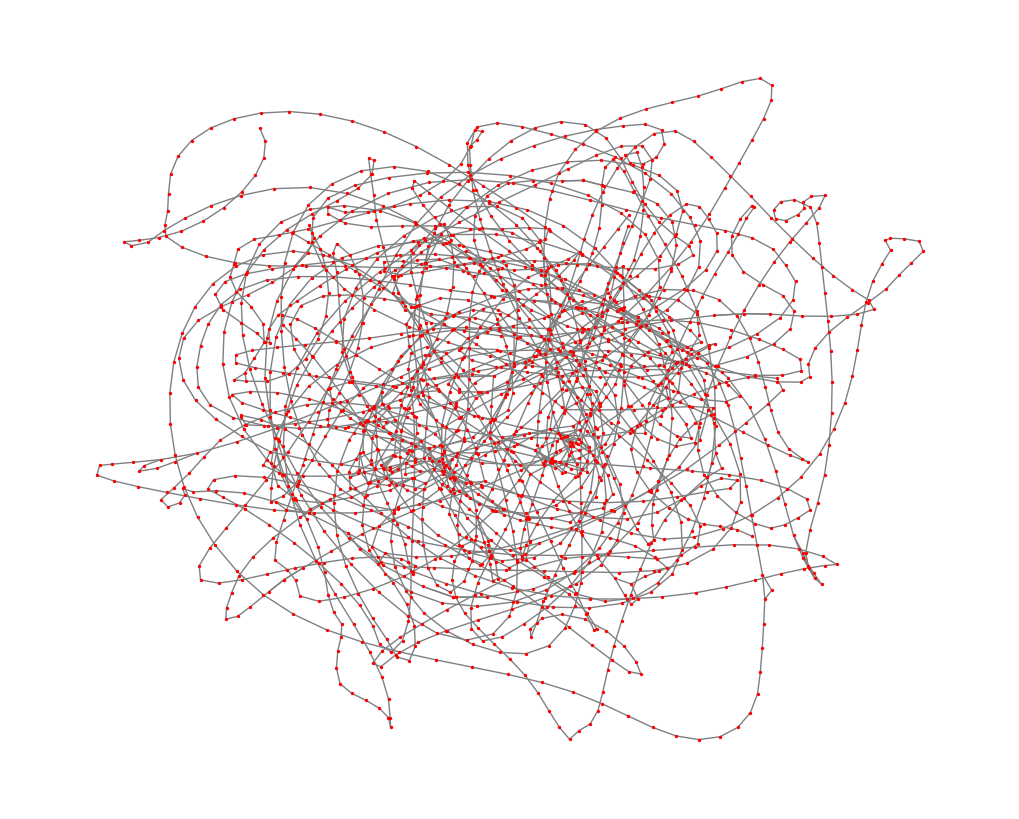

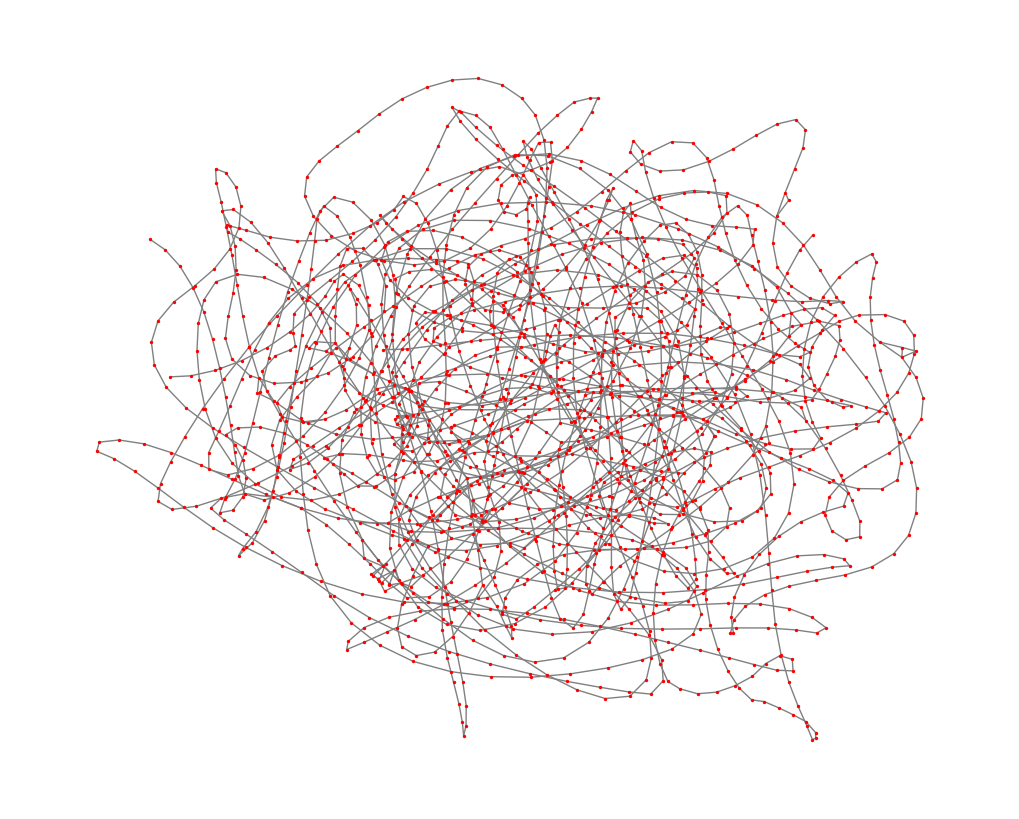

In [11]:
# plot merged graph

plt.figure(figsize=(10, 8))  # Set the figure size
nx.draw(merged_graph, with_labels=False, node_color='red', edge_color='gray', node_size = 2)
plt.show()

# plot joint graph

graph_all = nx.read_gml("/nfs/research/jlees/jacqueline/atb_analyses/merge_tests/staph_merge/graph_all/final_graph.gml")

plt.figure(figsize=(10, 8))  # Set the figure size
nx.draw(graph_all, with_labels=False, node_color='red', edge_color='gray', node_size = 2)
plt.show()

In [74]:
# add metadata (geneIDs)

gene_ids = {}
    centroids_to_nodes = defaultdict(list)
    for cluster in clusters:
        for sid in cluster:
            gene_ids[sid] = cluster[0]
    all_centroids = set(list(gene_ids.values()))
    
for G in graphs:
    for node in G.nodes():
        G.nodes[node]["geneID"] = list(
            set([
                gene_ids[sid] for sid in G.nodes[node]['seqIDs']
                if "refound" not in sid
            ]))
        for sid in G.nodes[node]["centroid"]:
            centroids_to_nodes[sid].append(node)
            
#        G.nodes[node]["dna"] = [
#            centroid_to_seqs[sid][1] for sid in G.nodes[node]["centroid"]
#        ]#
#
#        G.nodes[node]["protein"] = [
#            centroid_to_seqs[sid][0] for sid in G.nodes[node]["centroid"]
#        ]
#        G.nodes[node]["longCentroidID"] = max([
#            (len(seq), sid) for seq, sid in zip(G.nodes[node]["dna"],
#                                                G.nodes[node]["centroid"])
 #       ])

IndentationError: unexpected indent (1206283635.py, line 4)

In [75]:
# read in graph_all

graph_all = ["/nfs/research/jlees/jacqueline/atb_analyses/merge_tests/COG_merge/graph_all/final_graph.gml"]

graph_all, isolate_names, id_mapping = load_graphs(graph_all)
graph_all = graph_all[0]

#list(graph_all.nodes(data=True))

In [76]:
# define functions to generate dna hashes from node metadata

def match_uGID_sequences(G, sequences_g1, sequences_g2):
    
    # allows for mapping sequence GIDs to node UGIDs
    # only needed for G1 and G2 components of merged graph, not for graph_all
    
    # append uGID sequence keys (non-unique geneIDs) with uGID prefix
    prefix = "uGID_G1_"
    sequences_g1 = {f"{prefix}{key}": value for key, value in sequences_g1.items()}
    prefix = "uGID_G2_"
    sequences_g2 = {f"{prefix}{key}": value for key, value in sequences_g2.items()}

    # check that uGIDs are unique between sequence datasets
    overlapping_keys = set(sequences_g1.keys()) & set(sequences_g2.keys())
    if overlapping_keys:
        raise ValueError(f"Duplicate keys found: {overlapping_keys}")
            
    # combine uGID-labeled sequences from G1 and G2
    return ({**sequences_g1, **sequences_g2})

In [77]:
### map geneIDs (joint graph) and uGIDs (merged graph) to DNA sequences

# read in gene sequences
sequences_all = pd.read_csv('/nfs/research/jlees/jacqueline/atb_analyses/merge_tests/staph_merge/graph_all/gene_data.csv', usecols=["clustering_id", "dna_sequence"])
sequences_g1 = pd.read_csv('/nfs/research/jlees/jacqueline/atb_analyses/merge_tests/staph_merge/graph_1/gene_data.csv', usecols=["clustering_id", "dna_sequence"])
sequences_g2 = pd.read_csv('/nfs/research/jlees/jacqueline/atb_analyses/merge_tests/staph_merge/graph_2/gene_data.csv', usecols=["clustering_id", "dna_sequence"])

#print(sequences_g1)

# make into dictionaries
sequences_all = dict(zip(sequences_all["clustering_id"], sequences_all["dna_sequence"]))
sequences_g1 = dict(zip(sequences_g1["clustering_id"], sequences_g1["dna_sequence"]))
sequences_g2 = dict(zip(sequences_g2["clustering_id"], sequences_g2["dna_sequence"]))

#print(sequences_g1["0_0_0"])

sequences_merged = match_uGID_sequences(merged_graph, sequences_g1, sequences_g2)

#print(sequences_merged["uGID_G1_0_0_0"])

In [78]:
### hash DNA sequences
        
### use aaHash here instead!!
        
import hashlib

sequences_all = {key: hashlib.md5(str(value).encode()).hexdigest() for key, value in sequences_all.items()}
sequences_merged = {key: hashlib.md5(str(value).encode()).hexdigest() for key, value in sequences_merged.items()}

print(sequences_all)

{'0_0_0': 'c9a0c9a55d22486b0799c39012901efc', '0_0_1': '5804ec6f1a641656dece8bb849a96fd0', '0_0_2': '56af271b381e3f3dbd805f3d9d4a5363', '0_0_3': 'eb92619d82566b382473b8e9f691951c', '0_0_4': 'b6c9e6bd85b6cc8deb8bd85b0ae36daf', '0_0_5': '9d1d81db09ebdfe3635123c5fac78e50', '0_0_6': '5c1ebd6651335ef7894aa97436358e02', '0_0_7': '954562cb6ce27d124c28c813bb68c0fd', '0_0_8': 'b70106b110ebc84f1fb588e3c34922bd', '0_0_9': 'a0efcc1352459f217f05abe969842fd0', '0_0_10': '0f9f21f4a28624be7282cc9bfb3d2d11', '0_0_11': 'd5149d1916f68266845ee47b707426fe', '0_0_12': 'f6aae450901e3883ce223f1751c3bd0a', '0_0_13': '14770fe9d11bcfb063086ff0ee3bfd94', '0_0_14': 'dbe2547e2642a7cb57e5749670186a79', '0_0_15': '3c270df9a9febb5f3ed5fe9d65af34f2', '0_0_16': 'bd1773264237e9c6883a5429a6e164f9', '0_0_17': 'e4d0101dce2f6a422cb5211dbe58e59c', '0_0_18': '6a813d3bbdc57d5513fe98e83092068f', '0_0_19': 'bfb5bb4ab738234e96ea4c6b941c8efa', '0_0_20': '526d396361e1d5967a662683b113d66e', '0_0_21': '7ef2623d55d5a932beed4b67a125b9d1

In [79]:
### get dictionary with a hashed DNA sequence as the key and its cluster as the value

# get list of geneIDs/uGIDs in each node

def get_geneIDs_in_nodes(G):  

    # get individual gene IDs as keys, and the cluster each geneID belongs to as its value
    dictionary = {}
    
    for node in G.nodes():
        gene_ids = G.nodes[node].get("geneIDs", "error")
        #print(f"graph: 1, node_index_id: {node}, node_group_id: {node_group}")
        gene_ids = list(gene_ids.split(";"))
        
        for GID in gene_ids:
            dictionary[GID] = node
        
    return dictionary

cluster_dict_merged = get_geneIDs_in_nodes(merged_graph)
cluster_dict_all = get_geneIDs_in_nodes(graph_all)

#print(cluster_dict_merged)

# swap geneIDs/uGIDs for hashed DNA (remember we are mapping the two runs by hashed DNA, not by GID)

def match_hash_and_cluster(sequence, cluster):
    
    # Use keys from dict1 as the base order
    common_keys = [key for key in sequence if key in cluster]

    row1 = [sequence[key] for key in common_keys]
    row2 = [cluster[key] for key in common_keys]

    array_2d = pd.DataFrame([row1, row2])
    
    return array_2d
    
rand_input_merged = match_hash_and_cluster(sequences_merged, cluster_dict_merged)
rand_input_all = match_hash_and_cluster(sequences_all, cluster_dict_all)

# reorder merged dataset to match order of dna hashes in all dataset
rand_input_merged = rand_input_merged.reindex(columns=rand_input_all.columns)

# put sorted clusters into Rand index
ri = rand_score(rand_input_all.iloc[1], rand_input_merged.iloc[1])
print(f"Rand Index: {ri}")

ari = adjusted_rand_score(rand_input_all.iloc[1], rand_input_merged.iloc[1])
print(f"Adjusted Rand Index: {ari}")

# put sorted clusters into mutual information
mutual_info = mutual_info_score(rand_input_all.iloc[1], rand_input_merged.iloc[1])
print(f"Mutual Information: {mutual_info}")

adj_mutual_info = adjusted_mutual_info_score(rand_input_all.iloc[1], rand_input_merged.iloc[1])
print(f"Adjusted Mutual Information: {adj_mutual_info}")

Rand Index: 0.9814521273122686
Adjusted Rand Index: 0.0018387441836248014
Mutual Information: 4.163790413038751
Adjusted Mutual Information: 0.01055230477001889


In [ ]:
# context search

G.neighbors() # from nx